In [7]:
## Import packages

import pypsa
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import yaml
import warnings
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from cmcrameri import cm
import geopandas as gpd
from shapely import wkt
import xarray as xr
import matplotlib.colors as mcolors
from pypsa.descriptors import get_switchable_as_dense as as_dense
import matplotlib.dates as mdates
from collections import defaultdict
from tqdm import tqdm

## Import results and filter NL

In [8]:
def load_and_filter_nl_network(file_path):
    """
    Load a PyPSA network and retain only components connected to Dutch ('NL') buses.
    """
    n = pypsa.Network(file_path)
    
    nl_buses = n.buses[n.buses.index.str.startswith("NL")].index

    n.remove("Load", n.loads[~n.loads.bus.isin(nl_buses)].index)
    n.remove("Store", n.stores[~n.stores.bus.isin(nl_buses)].index)
    n.remove("Generator", n.generators[~n.generators.bus.isin(nl_buses)].index)
    n.remove("Link", n.links[~n.links.bus0.isin(nl_buses) & ~n.links.bus1.isin(nl_buses)].index)
    n.remove("Bus", n.buses[~n.buses.index.isin(nl_buses)].index)
    n.remove("storage_units", n.storage_units[~n.storage_units.bus.isin(nl_buses)].index)
    
    return n

n2030_1 = r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2030-nohtates"
n2030_2 = r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2030-nohtates-2"
n2030_3 = r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2030-nohtates-3"
n2030_ht_1 = r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2030-htates"
n2030_ht_2 = r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2030-htates-2"
n2030_ht_3 = r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2030-htates-3"
n2050_1 = r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2050-nohtates"
n2050_2 = r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2050-nohtates-2"
n2050_3 = r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2050-nohtates-3"
n2050_ht_1 = r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2050-htates"
n2050_ht_2 = r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2050-htates-2"
n2050_ht_3 = r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2050-htates-3"

network_paths = {
    "n2030_1": r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2030-nohtates.nc",
    "n2030_2": r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2030-nohtates-2.nc",
    "n2030_3": r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2030-nohtates-3.nc",
    "n2030_ht_1": r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2030-htates.nc",
    "n2030_ht_2": r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2030-htates-2.nc",
    "n2030_ht_3": r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2030-htates-3.nc",
    "n2050_1": r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2050-nohtates.nc",
    "n2050_2": r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2050-nohtates-2.nc",
    "n2050_3": r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2050-nohtates-3.nc",
    "n2050_ht_1": r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2050-htates.nc",
    "n2050_ht_2": r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2050-htates-2.nc",
    "n2050_ht_3": r"C:\Users\Johannes\Documents\final-results\networks\base_s_16__3H_2050-htates-3.nc",
}

# Dictionary to store the loaded and filtered networks
networks = {}
for key, path in network_paths.items():
    networks[key] = load_and_filter_nl_network(path)

INFO:pypsa.io:Imported network base_s_16__3H_2030-nohtates.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_16__3H_2030-nohtates-2.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_16__3H_2030-nohtates-3.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_16__3H_2030-htates.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_16__3H_2030-htates-2.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_16__3H_2030-htates-3.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_16__3H_2050-

## Costs

In [ ]:
### Finding the mean costs with standard deviation

# Directory containing the CSVs
csv_path = r"C:\Users\Johannes\Documents\final-results\new_cost_csv"

# Only include files from that directory that are relevant to the 4 scenarios
all_files = [
    f for f in os.listdir(csv_path)
    if f.startswith("nodal_costs_") and f.endswith(".csv") and ("htates" in f or "nohtates" in f)
]

# Group by scenario key
scenario_groups = defaultdict(list)
for file in all_files:
    base_name = file.replace("nodal_costs_", "").replace(".csv", "")
    parts = base_name.rsplit("-", 1)
    scenario_key = parts[0] if parts[-1].isdigit() else base_name
    scenario_groups[scenario_key].append(file)

# Store final results
results = {}

for scenario, files in scenario_groups.items():
    total_costs = []
    for f in files:
        path = os.path.join(csv_path, f)
        try:
            # Load CSV
            df = pd.read_csv(path)

            # Filter for NL locations:
            # nl_df = df[df["location"].str.startswith("NL")]
            # total_cost = nl_df.iloc[:, 4:].sum().sum() / 1e9  # values are in the 5th column

            # Don't filter for NL locations:
            total_cost = df.iloc[:, 4:].sum().sum() / 1e9  # values are in the 5th column
            total_costs.append((f, total_cost))
        except Exception as e:
            print(f"Skipping {f}: {e}")

    if total_costs:
        values = np.array([val for _, val in total_costs])
        mean = np.mean(values)
        std = np.std(values)
        distances = np.abs(values - mean)
        closest_idx = np.argmin(distances)
        closest_file = total_costs[closest_idx][0]

        results[scenario] = {
            "mean_billion_eur": mean,
            "std_billion_eur": std,
            "closest_file": closest_file,
            "individual_results": total_costs
        }

# Print results
for scenario, data in results.items():
    print(f"\nScenario: {scenario}")
    print(f"  Mean total cost (billion EUR): {data['mean_billion_eur']:.4f}")
    print(f"  Std deviation (billion EUR): {data['std_billion_eur']:.4f}")
    print(f"  Closest file to mean: {data['closest_file']}")
    print("  Individual results:")
    for fname, val in data['individual_results']:
        print(f"    {fname}: {val:.4f}")



Scenario: s_16__3H_2030-htates
  Mean total cost (billion EUR): 225.0250
  Std deviation (billion EUR): 0.0413
  Closest file to mean: nodal_costs_s_16__3H_2030-htates-2.csv
  Individual results:
    nodal_costs_s_16__3H_2030-htates-2.csv: 225.0131
    nodal_costs_s_16__3H_2030-htates-3.csv: 224.9814
    nodal_costs_s_16__3H_2030-htates.csv: 225.0804

Scenario: s_16__3H_2030-nohtates
  Mean total cost (billion EUR): 225.2437
  Std deviation (billion EUR): 0.0912
  Closest file to mean: nodal_costs_s_16__3H_2030-nohtates-3.csv
  Individual results:
    nodal_costs_s_16__3H_2030-nohtates-2.csv: 225.3119
    nodal_costs_s_16__3H_2030-nohtates-3.csv: 225.3044
    nodal_costs_s_16__3H_2030-nohtates.csv: 225.1148

Scenario: s_16__3H_2050-htates
  Mean total cost (billion EUR): 250.7027
  Std deviation (billion EUR): 0.0001
  Closest file to mean: nodal_costs_s_16__3H_2050-htates.csv
  Individual results:
    nodal_costs_s_16__3H_2050-htates-2.csv: 250.7029
    nodal_costs_s_16__3H_2050-htat

In [32]:
### Weighted price of urban central heat

def load_weighted_prices_per_node(n, carrier="urban central heat"):
    """
    Calculate load-weighted marginal prices per node for a given carrier (like urban central heat).
    """
    # Select buses for the given carrier
    buses = n.buses[n.buses.carrier == carrier]
    bus_names = buses.index

    # Get marginal prices and load withdrawals
    prices = n.buses_t.marginal_price[bus_names]
    load = n.statistics.withdrawal(groupby="bus", aggregate_time=False, bus_carrier=carrier, aggregate_across_components=True).T
    prices = prices[load.columns]

    # Get node (location) of each bus
    node = buses.loc[load.columns, "location"]

    # Multiply price by load and group by node
    load_by_node = load.T.groupby(node).sum().T
    weighted_price = (load * prices).T.groupby(node).sum().T

    # Weighting for time snapshots
    weights = n.snapshot_weightings.generators
    a = weights @ weighted_price
    b = weights @ load_by_node

    # Load-weighted average price per node
    price_per_node = a / b

    return price_per_node.sort_values()

print("Only the Netherlands:")
print("Without HT-ATES:")
n = networks["n2050_1"]
prices = load_weighted_prices_per_node(n, carrier="urban central heat")
print(f"Mean load-weighted marginal price of urban central heat: {prices.mean():.2f} EUR/MWh")
print(f"Standard deviation: {prices.std():.2f} EUR/MWh")
print("With HT-ATES:")
n = networks["n2050_ht_1"]
prices_ht = load_weighted_prices_per_node(n, carrier="urban central heat")
print(f"Mean load-weighted marginal price of urban central heat: {prices_ht.mean():.2f} EUR/MWh")
print(f"Standard deviation: {prices_ht.std():.2f} EUR/MWh")
print(f"Decrease in price: {((prices_ht.mean()-prices.mean())/prices.mean())*100} ")

print("\n")
print("All five countries included:")
print("Without HT-ATES:")
os.chdir(r"C:\Users\Johannes\Documents\final-results\networks")
n = pypsa.Network("base_s_16__3H_2050-nohtates.nc")
prices = load_weighted_prices_per_node(n, carrier="urban central heat")
print(f"Mean load-weighted marginal price of urban central heat: {prices.mean():.2f} EUR/MWh")
print(f"Standard deviation: {prices.std():.2f} EUR/MWh")
print("With HT-ATES:")
os.chdir(r"C:\Users\Johannes\Documents\final-results\networks")
n = pypsa.Network("base_s_16__3H_2050-htates.nc")
prices_ht = load_weighted_prices_per_node(n, carrier="urban central heat")
print(f"Mean load-weighted marginal price of urban central heat: {prices_ht.mean():.2f} EUR/MWh")
print(f"Standard deviation: {prices_ht.std():.2f} EUR/MWh")
print(f"Decrease in price: {((prices_ht.mean()-prices.mean())/prices.mean())*100} ")

Only the Netherlands:
Without HT-ATES:
Mean load-weighted marginal price of urban central heat: 32.50 EUR/MWh
Standard deviation: 9.96 EUR/MWh
With HT-ATES:
Mean load-weighted marginal price of urban central heat: 30.24 EUR/MWh
Standard deviation: 7.59 EUR/MWh
Decrease in price: -6.958685059533917 


All five countries included:
Without HT-ATES:


INFO:pypsa.io:Imported network base_s_16__3H_2050-nohtates.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Mean load-weighted marginal price of urban central heat: 33.18 EUR/MWh
Standard deviation: 9.84 EUR/MWh
With HT-ATES:


INFO:pypsa.io:Imported network base_s_16__3H_2050-htates.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Mean load-weighted marginal price of urban central heat: 31.63 EUR/MWh
Standard deviation: 8.53 EUR/MWh
Decrease in price: -4.682136921693403 


## HT-ATES: state of charge, amount of systems per location

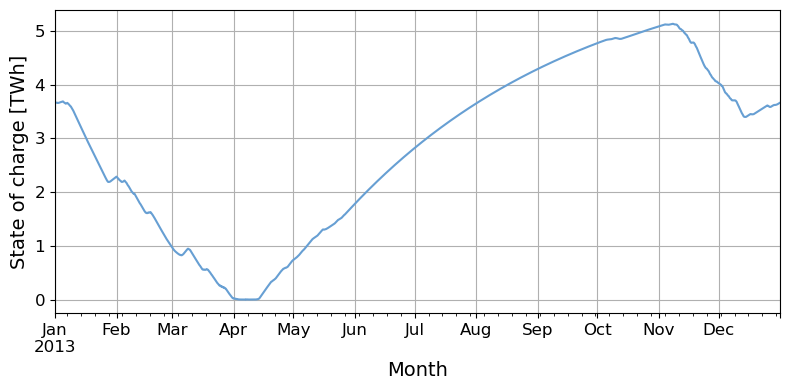

In [ ]:
### State of charge

n = networks["n2050_ht_1"]
ht_ates_stores = n.stores[n.stores.carrier == "urban central ht_ates"]
soc = n.stores_t.e[ht_ates_stores.index] /1000000

plt.figure(figsize=(8, 4))
soc.sum(axis=1).plot(color=cm.managua(0.85))
#plt.title("Total HT-ATES State of Charge", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("State of charge [TWh]", fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.grid(True)
# os.chdir(r"C:\Users\Johannes\Documents\final-results\Figures")
# plt.savefig('stateofcharge-2050.png',dpi=400)
plt.show()

79.39171462906165


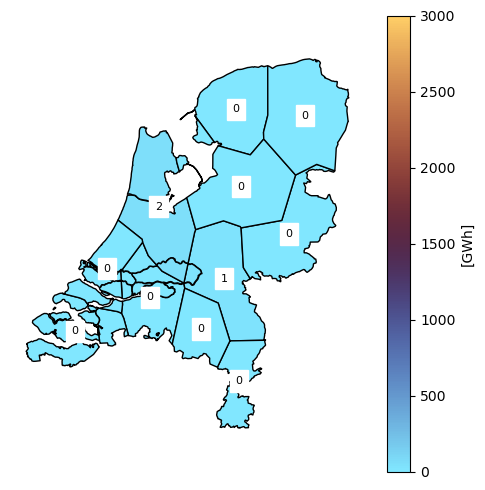

In [ ]:
### HT-ATES systems installed

n = networks["n2030_ht_1"]
# Load the spatial geometries
clusters_gdf = gpd.read_file(r"C:\Users\Johannes\PypsaProject\pypsa-eur-htates\resources\regions_onshore_base_s_16.geojson")
clusters_gdf = clusters_gdf[clusters_gdf["name"].str.contains("NL0")].copy()

# Get HT-ATES optimised storage data
ht_ates_stores = n.stores[n.stores.carrier == "urban central ht_ates"].copy()
ht_ates_stores = ht_ates_stores.reset_index()
# Extract the matching cluster name from the store index string
ht_ates_stores["name"] = ht_ates_stores["Store"].str.extract(r"(NL0 \d+)")

# Add converted capacity values
ht_ates_stores["e_nom_opt_gwh"] = ht_ates_stores["e_nom_opt"] / 1000  # MWh → GWh
ht_ates_stores["n_systems"] = (ht_ates_stores["e_nom_opt"] / 20000).fillna(0).round().astype(int) # Assuming 1 system has a capacity of 20 GWh
# Print the total installed capacity
print(ht_ates_stores["e_nom_opt_gwh"].sum())
# Merge with the spatial data
plot_df = clusters_gdf.merge(
    ht_ates_stores[["name", "e_nom_opt_gwh", "n_systems"]],
    on="name", how="left")
plot_df["e_nom_opt_gwh"] = plot_df["e_nom_opt_gwh"].fillna(0)
plot_df["n_systems"] = plot_df["n_systems"].fillna(0).astype(int)

# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
plot_df.plot(column="e_nom_opt_gwh", cmap=cm.managua.reversed(), legend=True, ax=ax, vmin=0, vmax=3000,
    edgecolor='black', legend_kwds={'label': "[GWh]"})
for _, row in plot_df.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, f"{row['n_systems']}",
            fontsize=8, ha='center', va='center', color='black', backgroundcolor='white')
#plt.title("Installed HT-ATES Systems")
plt.axis('off')
plt.tight_layout()
# os.chdir(r"C:\Users\Johannes\Documents\final-results\Figures")
# plt.savefig('installedHTATES-2030.png',dpi=400)
plt.show()

## Share of HT-ATES in district heating

Total urban central heating demand: 155.23657102114 TWh
Fraction of urban central heat used for district heating: 0.434
Total heat that supplies district heating: 67.4332543254172 TWh


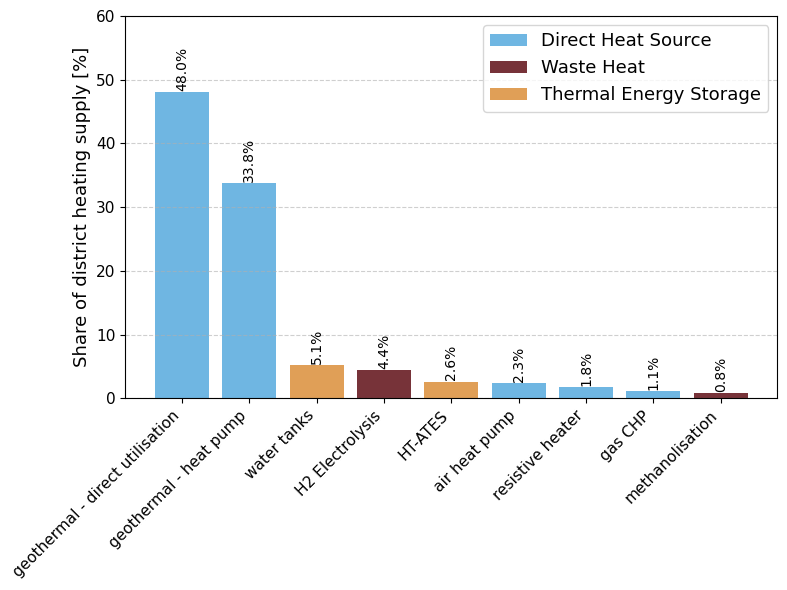


District Heating Supply by Source [MWh]:
Source
geothermal - direct utilisation    3.237161e+07
geothermal - heat pump             2.279142e+07
water tanks                        3.470585e+06
H2 Electrolysis                    2.990767e+06
HT-ATES                            1.767135e+06
air heat pump                      1.572503e+06
resistive heater                   1.185829e+06
gas CHP                            7.543561e+05
methanolisation                    5.131190e+05
gas boiler                         1.590383e+04
gas CHP CC                         1.162311e+01
Fischer-Tropsch                    1.277565e+00
solid biomass CHP CC               1.250469e+00
solid biomass CHP                  1.166868e+00
H2 Fuel Cell                       7.959033e-01
Sabatier                           5.751061e-01
dtype: float64


In [10]:
n = networks["n2050_ht_1"]

# Get the energy balance
eb = n.statistics.energy_balance(aggregate_time="sum")

# Calculate fraction of heat going to final demand (not DAC, storage, etc.)
uc_outflows = eb[
    (eb < 0) & 
    (eb.index.get_level_values("bus_carrier") == "urban central heat")
].abs()
total_uc_outflow = uc_outflows.sum()

# Only keep outflows going to 'Load' components (so the heating demand)
uc_final_demand = uc_outflows[
    uc_outflows.index.get_level_values("component") == "Load"
].sum()
fraction_to_demand = uc_final_demand / total_uc_outflow
print(f"Total urban central heating demand: {total_uc_outflow/1e6} TWh")
print(f"Fraction of urban central heat used for district heating: {fraction_to_demand:.3f}")

# Collect contributions into urban central heat bus (p0–p4)
link_p_cols = [col for col in n.links_t.keys() if col.startswith("p")]
district_heat_contributions = {}

weightings = n.snapshot_weightings.generators
for i in range(5):  # loop over buses 0 to 4
    p_col = f"p{i}"       
    bus_col = f"bus{i}"   

    if p_col in n.links_t and bus_col in n.links.columns:
        for link_id, link in n.links.iterrows():
            heat_bus = link[bus_col]
            if isinstance(heat_bus, str) and "urban central heat" in heat_bus.lower():
                try:
                    dispatch = n.links_t[p_col][link_id]
                except KeyError:
                    continue
                weighted_dispatch = dispatch * weightings
                energy = weighted_dispatch[dispatch < 0].sum()
                if energy != 0:
                    carrier_label = link.carrier + f" (p{i})"
                    # Apply scaling to reflect only demand-serving heat
                    scaled_energy = energy * fraction_to_demand
                    district_heat_contributions[carrier_label] = (
                        district_heat_contributions.get(carrier_label, 0) + scaled_energy
                    )

# Clean labels and classify sources
waste_heat_carriers = [
    "Fischer-Tropsch", "Sabatier", "methanolisation", "H2 Electrolysis", "H2 Fuel Cell"]
thermal_storage_keywords = ["discharger"]

labels_cleaned = []
source_type = []  # "waste", "storage", "direct"
for label in district_heat_contributions:
    name = label.split(" (")[0]
    name = name.replace("urban central ", "").replace("urban decentral ", "").replace(" discharger", "")
    if name == "ht_ates":
        name = "HT-ATES"
    if name == "geothermal heat direct utilisation":
        name = "geothermal - direct utilisation"
    if name == "geothermal heat pump":
        name = "geothermal - heat pump"
    if any(name.startswith(w) for w in waste_heat_carriers):
        label_type = "waste"
    elif name in ["HT-ATES", "water tanks"]:
        label_type = "storage"
    else:
        label_type = "normal"
    source_type.append(label_type)
    labels_cleaned.append(name)

# Find the heat contributions in percentages
dh_contribs = pd.Series(district_heat_contributions)
dh_contribs.index = labels_cleaned
dh_contribs = dh_contribs.groupby([dh_contribs.index, pd.Index(source_type)]).sum().abs()
dh_contribs.index.names = ["Source", "Type"]
print(f"Total heat that supplies district heating: {dh_contribs.sum()/1e6} TWh")
dh_percent = (dh_contribs / dh_contribs.sum()) * 100
dh_percent = dh_percent.sort_values(ascending=False)
# Filter out sources with < 0.05% contribution
dh_percent = dh_percent[dh_percent >= 0.05]

# Plotting
colors = {"normal": cm.managua(0.9), "waste": cm.managua(0.4), "storage": cm.managua(0.1)}
color_list = [colors[typ] for _, typ in dh_percent.index]
plt.figure(figsize=(8, 6))
bars = plt.bar([src for src, _ in dh_percent.index], dh_percent.values, color=color_list)
plt.ylabel("Share of district heating supply [%]", fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0, 60)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
for bar, pct in zip(bars, dh_percent.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=10, rotation=90)
legend_elements = [
    Patch(facecolor=colors["normal"], label='Direct Heat Source'),
    Patch(facecolor=colors["waste"], label='Waste Heat'),
    Patch(facecolor=colors["storage"], label='Thermal Energy Storage'),
]
plt.legend(handles=legend_elements, loc="upper right", fontsize=13)
plt.show()

# Print the results from the plot
print("\nDistrict Heating Supply by Source [MWh]:")
print(dh_contribs.droplevel(1).sort_values(ascending=False))

## Energy demand

 just NL: component  carrier                            bus_carrier         
Load       agriculture heat                   rural heat              33.378547
           low-temperature heat for industry  urban central heat      10.990000
           rural heat                         rural heat               6.980322
           urban central heat                 urban central heat      27.708519
           urban decentral heat               urban decentral heat    90.804267
Name: objective, dtype: float64


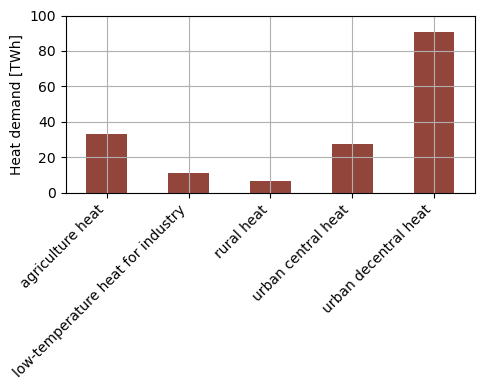

In [ ]:
### Demand per heat subsector

n = networks["n2030_ht_1"]
load_stats = n.statistics.energy_balance(comps=["Load"], aggregate_time="sum")
heating_stats_GWh = load_stats[load_stats.index.get_level_values('carrier').str.contains('heat', case=False)]

heating_stats_TWh = abs(heating_stats_GWh/1000000)
print(f" Demand per subsector: {heating_stats_TWh}")
ax = plt.figure(figsize=(5,4))
ax = heating_stats_TWh.plot.bar(
    #title='Demand of heating subsectors in 2050',
    xlabel="",
    ylabel="Heat demand [TWh]",
    color='#92463b')
ax.set_ylim(0,100)
ax.set_xticklabels(heating_stats_TWh.index.get_level_values('carrier'), rotation=45, ha="right")
ax.grid(True)
plt.tight_layout()
# os.chdir(r"C:\Users\Johannes\Documents\final-results\Figures")
# plt.savefig('heatdemand-subsectors-2030.png',dpi=400)
plt.show()

C:\Users\Johannes\AppData\Local\Temp\ipykernel_14676\1442449213.py:25: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\Johannes\AppData\Local\Temp\ipykernel_14676\1442449213.py:25: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



{'electricity': '#ffcf67', 'heat': '#92463b', 'methane': '#4e5593', 'hydrogen': '#81e7ff'}


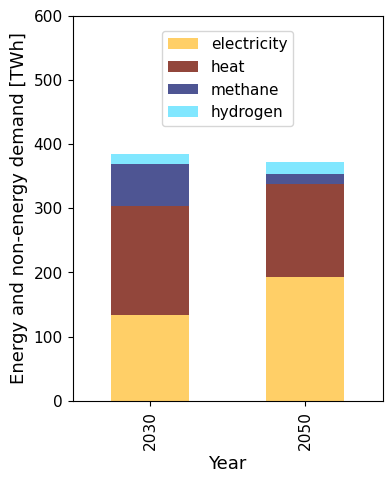

In [ ]:
### Total energy demand per year

# Category mapping
mapping = {
    "H2 for industry": "hydrogen",
    "agriculture electricity": "electricity",
    "agriculture heat": "heat",
    "electricity": "electricity",
    "gas for industry": "methane",
    "industry electricity": "electricity",
    "land transport EV": "electricity",
    "low-temperature heat for industry": "heat",
    "rural heat": "heat",
    "urban decentral heat": "heat",
    "urban central heat": "heat",
}

order = ["electricity", "heat", "methane", "hydrogen"]

# Helper function to process a network
def compute_demand_breakdown(n, year_label):
    demand = as_dense(n, "Load", "p_set").div(1e6)  # Convert to TWh
    demand_grouped = demand.groupby(
        [n.loads.carrier, n.loads.bus.map(n.buses.location)], axis=1
    ).sum()
    demand_by_region = (n.snapshot_weightings.generators @ demand_grouped).unstack(level=0)

    df = demand_by_region.sum()
    df.index = pd.MultiIndex.from_tuples([(mapping.get(i, i), i) for i in df.index])
    df = df[~df.index.get_level_values(0).isin(["emissions"])]
    df_grouped = df.groupby(level=0).sum().loc[order]
    return pd.DataFrame(df_grouped).T.rename(index={0: year_label})

# Load and process both networks
n_2050 = networks["n2050_ht_1"]
n_2030 = networks["n2030_ht_1"]

df_2050 = compute_demand_breakdown(n_2050, "2050")
df_2030 = compute_demand_breakdown(n_2030, "2030")

cmap = cm.managua
colors = {tech: mcolors.to_hex(cmap(i / (len(order) - 1))) for i, tech in enumerate(order)}
print(colors)

# Plotting
df_plot = pd.concat([df_2030, df_2050])
fig, ax = plt.subplots(figsize=(4, 5))
df_plot.plot.bar(
    ax=ax,
    stacked=True,
    color=[colors[k] for k in df_plot.columns],
)
ax.set_ylim([0, 600])
ax.set_ylabel("Energy and non-energy demand [TWh]", fontsize=13)
ax.set_xlabel("Year", fontsize=13)
#ax.set_title("Dutch energy and non-energy demand", fontsize=14, pad=20)
ax.tick_params(axis='both', labelsize=11)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 0.98),
    fontsize=11)
# os.chdir(r"C:\Users\Johannes\Documents\final-results\Figures")
# plt.savefig('energydemand.png',dpi=400)
plt.show()

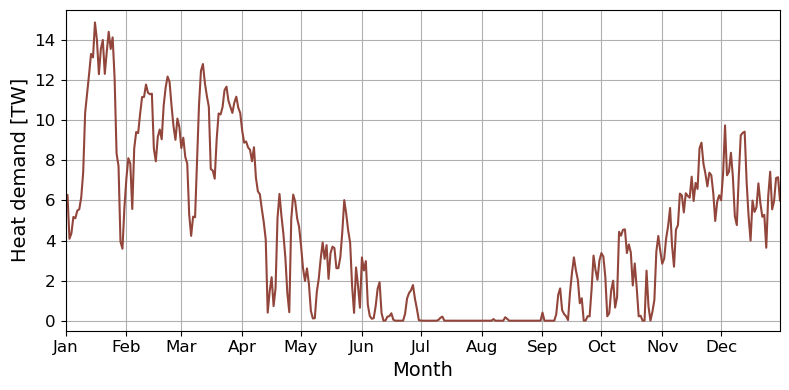

In [ ]:
### Daily heat demand in NL

ds = xr.open_dataset(r"C:\Users\Johannes\PypsaProject\pypsa-eur-htates\resources\daily_heat_demand_total_base_s_1.nc")

plt.figure(figsize=(8, 4))
plt.plot(ds.time, ds.heat_demand / 1e6, color='#92463b')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # 'Jan', 'Feb', etc.
plt.xlim(ds.time.values[0], ds.time.values[-1])
#plt.title("Daily heat demand of the Netherlands - 2050", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Heat demand [TW]", fontsize=14)
plt.ylim(-0.5,15.5)
plt.tick_params(axis='both', labelsize=12)
plt.grid(True)
plt.tight_layout()
# os.chdir(r"C:\Users\Johannes\Documents\final-results\Figures")
# plt.savefig('heatdemandyear.png',dpi=400)
plt.show()

## Heat production and demand

In [ ]:
# Code mostly based on plot_balance_timeseries.py from pypsa-eur 

# Load the filtered NL network
os.chdir(r"C:\Users\Johannes\Documents\final-results\networks")
n = pypsa.Network("base_s_16__3H_2050-htates.nc")
# Load config.yaml
with open(r"C:\Users\Johannes\PypsaProject\pypsa-eur-htates\results\batch_1207\2050-htates\configs\config.base_s_16__3H_2050.yaml", encoding="windows-1252") as f:
    full_config = yaml.safe_load(f)
config = full_config["plotting"]["balance_timeseries"]

# Add missing geothermal and HT-ATES-related carriers to the heat group
additional_heat_carriers = [
    "urban central ht_ates charger",
    "urban central ht_ates discharger",
    "urban central geothermal heat pump",
    "urban central geothermal heat direct utilisation"
]

# Avoid duplicates
existing_heat_group = config["carrier_groups"].get("heat", [])
for carrier in additional_heat_carriers:
    if carrier not in existing_heat_group:
        existing_heat_group.append(carrier)
config["carrier_groups"]["heat"] = existing_heat_group

# Add to full list of carriers
for carrier in additional_heat_carriers:
    if carrier not in config["carriers"]:
        config["carriers"].append(carrier)

# Filter for NL
nl_buses = n.buses[n.buses.index.str.startswith("NL")].index
n.remove("Load", n.loads[~n.loads.bus.isin(nl_buses)].index)
n.remove("Store", n.stores[~n.stores.bus.isin(nl_buses)].index)
n.remove("Generator", n.generators[~n.generators.bus.isin(nl_buses)].index)
n.remove("Link", n.links[~n.links.bus0.isin(nl_buses) & ~n.links.bus1.isin(nl_buses)].index)
n.remove("Bus", n.buses[~n.buses.index.isin(nl_buses)].index)
n.remove("StorageUnit", n.storage_units[~n.storage_units.bus.isin(nl_buses)].index)

# Plotting setup
plt.style.use("bmh")
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Plotting functions
def plot_stacked_area_steplike(ax, df, colors={}):
    if isinstance(colors, pd.Series):
        colors = colors.to_dict()
    df_cum = df.cumsum(axis=1)
    previous = np.zeros_like(df_cum.iloc[:, 0].values)
    for col in df_cum.columns:
        ax.fill_between(
            df_cum.index,
            previous,
            df_cum[col],
            step="pre",
            linewidth=0,
            color=colors.get(col, "grey"),
            label=col,
        )
        previous = df_cum[col].values

def setup_time_axis(ax, timespan):
    if timespan > pd.Timedelta(weeks=5):
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%e\n%b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%e"))
    else:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%e\n%b"))
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%e"))
    ax.tick_params(axis="x", which="minor", labelcolor="grey")

def plot_energy_balance_timeseries(
    df,
    time=None,
    ylim=None,
    resample=None,
    rename={},
    preferred_order=[],
    ylabel="",
    colors={},
    max_threshold=0.0,
    mean_threshold=0.0,
    directory="",
):
    if time is not None:
        df = df.loc[time]

    exempt_from_other = {
        "urban central ht_ates charger",
        "urban central ht_ates discharger",
        "urban central geothermal heat pump",
        "rural heat"
    }

    techs_below_threshold = [
        tech for tech in df.columns
        if tech not in exempt_from_other and
        (df[tech].abs().max() < max_threshold) and
        (df[tech].abs().mean() < mean_threshold)
    ]
    if techs_below_threshold:
        rename.update({tech: "other" for tech in techs_below_threshold})
        colors["other"] = "grey"

    rename.update({
        "urban central ht_ates charger": "urban central HT-ATES charger",
        "urban central ht_ates discharger": "urban central HT-ATES discharger",
        "urban central geothermal heat pump": "urban central geothermal heat pump"
    })

    if rename:
        df = df.T.groupby(df.columns.map(lambda a: rename.get(a, a))).sum().T

    if resample is not None:
        df = df.resample("1h").ffill().resample(resample).mean()

    order = (df / df.max()).var().sort_values().index
    if preferred_order:
        order = pd.Index(preferred_order).intersection(order).append(order.difference(preferred_order))
    df = df.loc[:, order]

    pos = df.where(df > 0).fillna(0.0)
    neg = df.where(df < 0).fillna(0.0)

    fig, ax = plt.subplots(figsize=(10, 4.5), layout="constrained")
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    plot_stacked_area_steplike(ax, pos, colors)
    plot_stacked_area_steplike(ax, neg, colors)

    plt.xlim((df.index[0], df.index[-1]))
    setup_time_axis(ax, df.index[-1] - df.index[0])

    ax.grid(axis="y")
    ax.axhline(0, color="grey", linewidth=0.5)

    if ylim is None:
        ylim = np.ceil(max(-neg.sum(axis=1).min(), pos.sum(axis=1).max()) / 50) * 50
    plt.ylim([-ylim, ylim])

    plt.ylabel(f"{ylabel} balance [GW]")
    handles, labels = ax.get_legend_handles_labels()
    half = int(len(handles) / 2)
    legend = fig.legend(handles[:half], labels[:half], loc="outside right upper", fontsize=6)
    legend.get_frame().set_facecolor("white")  # Set white background
    legend.get_frame().set_edgecolor("grey") 

    if resample is None:
        if isinstance(time, pd.DatetimeIndex) and len(time) > 0:
            time_str = time[0].strftime("%Y-%m")
        else:
            time_str = "default"
        resample = f"native-{time_str}"
    fn = f"ts-balance-{ylabel.replace(' ', '_')}-{resample}.pdf"
    plt.savefig(os.path.join(directory, fn))
    plt.close()

def process_carrier(group_item, balance, months, colors, config, output_dir):
    group, carriers = group_item
    if not isinstance(carriers, list):
        carriers = [carriers]

    mask = balance.index.get_level_values("bus_carrier").isin(carriers)
    df = balance[mask].groupby("carrier").sum().div(1e3).T

    kwargs = dict(
        ylabel=group,
        colors=colors,
        max_threshold=config["max_threshold"],
        mean_threshold=config["mean_threshold"],
        directory=output_dir,
    )

    if config["annual"]:
        plot_energy_balance_timeseries(df, resample=config["annual_resolution"], **kwargs)

# Load energy balance
balance = n.statistics.energy_balance(aggregate_time=False, nice_names=False)

# Colors 
n.carriers["color"] = n.carriers["color"].replace("", "grey")
colors = n.carriers.color.copy()
colors["urban central HT-ATES charger"] = "#531ae4"
colors["urban central HT-ATES discharger"] = "#ff0004"

# Groups
groups = config["carrier_groups"].copy()
groups.update({c: [c] for c in config["carriers"]})
available_carriers = set(n.buses.carrier.unique())
groups = {k: v for k, v in groups.items() if not set(v).isdisjoint(available_carriers)}

# Time slices
snapshots = n.snapshots
months = snapshots.to_series().groupby(snapshots.to_series().dt.to_period("M")).apply(lambda x: x.index)

# Run
for group_item in tqdm(groups.items(), desc="Plotting groups"):
    process_carrier(group_item, balance, months, colors, config, output_dir)

## General

HT-ATES potential per cluster

6465.884027489357


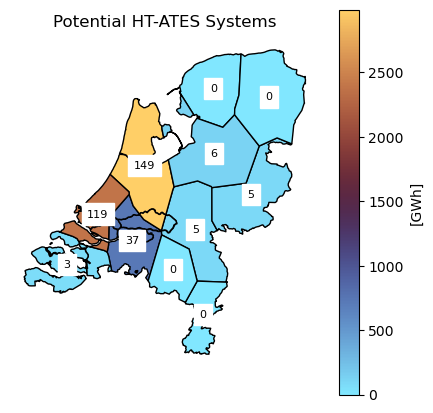

In [ ]:
# HT-ATES potential (so not what is installed, but the potential based on the TNO maps)
htates_potential = pd.read_csv(r"C:\Users\Johannes\PypsaProject\pypsa-eur-htates\resources\htates_potentials_base_s_16_2030.csv",
                                header=0, usecols=[1,2,3], skiprows=[1,2,3,4])
htates_potential['geometry'] = htates_potential['geometry'].apply(wkt.loads)
htates_potential = gpd.GeoDataFrame(htates_potential, geometry='geometry')
htates_potential = htates_potential[htates_potential['name.1'].str.contains("NL", na=False)]

# Convert MWh to GWh for consistent units
htates_potential['htates_potential_gwh'] = htates_potential['htates_potential'] / 1000
# Calculate number of HT-ATES systems (1 system = 20 GWh)
htates_potential['n_systems'] = (htates_potential['htates_potential_gwh'] / 20).round(0).astype(int)
print(htates_potential['htates_potential_gwh'].sum())
# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
# Plot using GWh values
htates_potential.plot(
    column='htates_potential_gwh',
    cmap=cm.managua.reversed(),
    legend=True,
    ax=ax,
    edgecolor='black',
    legend_kwds={'label': "[GWh]"}
)
# Add text annotations showing the number of systems
for idx, row in htates_potential.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y,
            f"{row['n_systems']}",
            fontsize=8, ha='center', va='center', color='black', backgroundcolor='white')
plt.title("Potential HT-ATES Systems")
plt.axis('off')
plt.show()


Plotting the network

INFO:pypsa.io:Imported network base_s_16__3H_2050-htates.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
c:\Users\Johannes\miniconda3\envs\pypsa-eur-clean\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



(<matplotlib.collections.PatchCollection at 0x12c404b4740>,
 <matplotlib.collections.LineCollection at 0x12c3f51d6a0>)

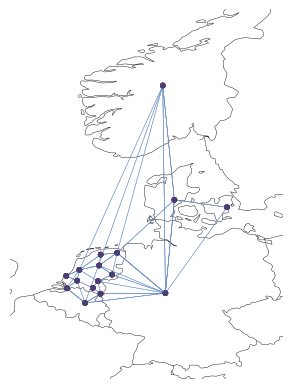

In [36]:
os.chdir(r"C:\Users\Johannes\Documents\final-results\networks")
n = pypsa.Network("base_s_16__3H_2050-htates.nc")

countries = ["NL", "BE", "DE", "DK", "NO"]
keep_buses = n.buses[n.buses.country.isin(countries)].index

# Remove all components not attached to these buses
n.remove("Load", n.loads[~n.loads.bus.isin(keep_buses)].index)
n.remove("Store", n.stores[~n.stores.bus.isin(keep_buses)].index)
n.remove("Generator", n.generators[~n.generators.bus.isin(keep_buses)].index)
n.remove("Link", n.links[~n.links.bus0.isin(keep_buses) & ~n.links.bus1.isin(keep_buses)].index)
n.remove("Line", n.lines[~n.lines.bus0.isin(keep_buses) & ~n.lines.bus1.isin(keep_buses)].index)
n.remove("Bus", n.buses[~n.buses.index.isin(keep_buses)].index)

plt.figure()
n.plot(
    margin=0.35,
    #bus_sizes=(n.loads.groupby("bus").p_set.sum() / 1e4), #0.015
    bus_colors="#4c3d739d",
    bus_alpha=0.4,
    line_colors="#5f89c3a5",
    link_colors="#5f89c3a5",
    line_widths=0.3,
    link_widths=0.3,
    line_alpha=0.5,
    link_alpha=0.5
)

## Tornado diagram for sensitivity analysis


Average base cost from n0–n2: 250.7027 billion EUR
base max is 0.00011079485143742698 % higher than base min
Standard deviation in percentage: 3.9887882846424295e-05 %
The results that are depicted in the graph:
Level                           -25        25       100
Parameter                                              
Marginal cost             -0.000089  0.000038       NaN
FOM                       -0.003567  0.003786       NaN
DH area buffer             0.003886 -0.002876       NaN
Lifetime                   0.004703 -0.001708       NaN
Include possible barriers       NaN       NaN -0.012101
Investment cost           -0.014589  0.013451       NaN
Energy to power ratio     -0.019210  0.014712       NaN


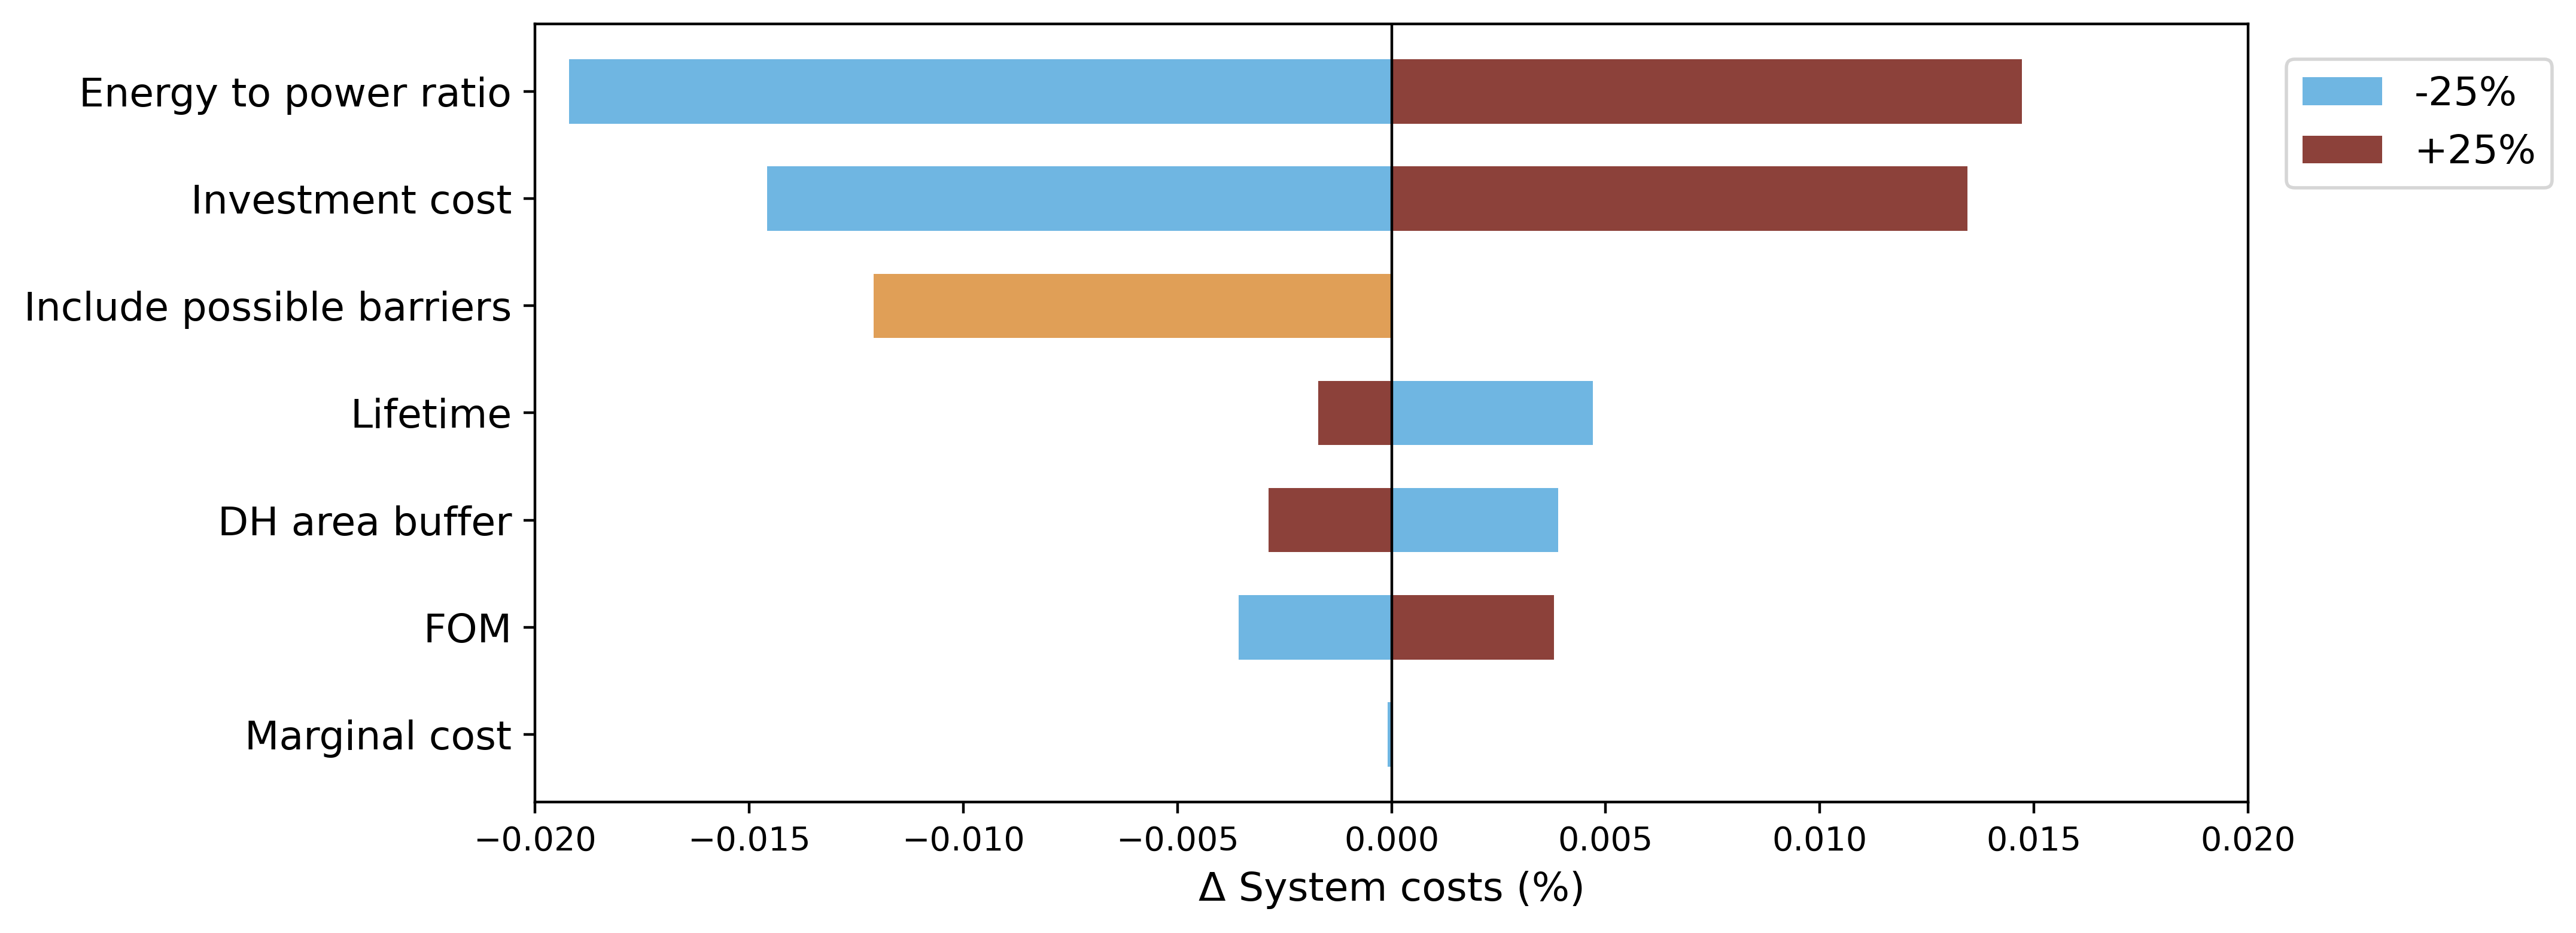

In [5]:
csv_path = r"C:\Users\Johannes\Documents\final-results\nodal_costs"

# Map scenario keys to filenames
scenario_suffixes = {
    "n0": "nodal_costs_s_16__3H_2050-htates",
    "n1": "nodal_costs_s_16__3H_2050-htates-2",
    "n2": "nodal_costs_s_16__3H_2050-htates-3",
    "ni75": "nodal_costs_s_16__3H_2050-i75",
    "ni125": "nodal_costs_s_16__3H_2050-i125",
    "nm75": "nodal_costs_s_16__3H_2050-m75-2",
    "nm125": "nodal_costs_s_16__3H_2050-m125",
    # "nc75": "nodal_costs_s_12__3H_2050",
    # "nc125": "nodal_costs_s_20__3H_2050",
    "nyellow": "nodal_costs_s_16__3H_2050-yellow",
    # "nnohtates": "nodal_costs_s_16__3H_2050-nohtates-3",
    "ndh75": "nodal_costs_s_16__3H_2050-dh75",
    "ndh125": "nodal_costs_s_16__3H_2050-dh125",
    "nlt75": "nodal_costs_s_16__3H_2050-lt75",
    "nlt125": "nodal_costs_s_16__3H_2050-lt125",
    "nf75": "nodal_costs_s_16__3H_2050-f75",
    "nf125": "nodal_costs_s_16__3H_2050-f125",
    "nep75": "nodal_costs_s_16__3H_2050-ep75",
    "nep125": "nodal_costs_s_16__3H_2050-ep125",
    # "nall75": "nodal_costs_s_16__3H_2050-all75",
}
# Mapping of scenarios to parameters
parameter_map = {
    "nm75": ("Marginal cost", -25),
    "nm125": ("Marginal cost", +25),
    "ni75": ("Investment cost", -25),
    "ni125": ("Investment cost", +25),
    # "nc75": ("Number of clusters", -25),
    # "nc125": ("Number of clusters", +25),
    "nyellow": ("Include possible barriers", +100),
    # "nnohtates": ("No HT-ATES", -100),
    "ndh75": ("DH area buffer", -25),
    "ndh125": ("DH area buffer", +25),
    "nlt75": ("Lifetime", -25),
    "nlt125": ("Lifetime", +25),
    "nf75": ("FOM", -25),
    "nf125": ("FOM", +25),
    "nep75": ("Energy to power ratio", -25),
    "nep125": ("Energy to power ratio", +25),
    # "nall75": ("All parameters -25%", -25)
}

# Load costs
nodal_costs_billion_eur = {}
for name, filename in scenario_suffixes.items():
    file_path = os.path.join(csv_path, f"{filename}.csv")
    try:
        costs = pd.read_csv(file_path, header=[0], index_col=[0, 1, 2, 3])
        costs.index.names = ["cost", "component", "location", "carrier"]
        total_cost_nl = costs.sum().sum() / 1e9
        nodal_costs_billion_eur[name] = total_cost_nl
    except Exception as e:
        print(f"Error loading {name}: {e}")

# Create DataFrame
costs_df = pd.DataFrame.from_dict(nodal_costs_billion_eur, orient="index", columns=["Cost_BEUR"])
# Average base cost from n0–n2
base_keys = ["n0", "n1", "n2"]
base_cost = costs_df.loc[base_keys].mean().values[0]
print(f"\nAverage base cost from n0–n2: {base_cost:.4f} billion EUR")

# Build tornado-style table
plot_data = []
for key, (param, level) in parameter_map.items():
    delta = (costs_df.loc[key, "Cost_BEUR"] - base_cost) / base_cost * 100
    plot_data.append((param, level, delta))
tornado_df = pd.DataFrame(plot_data, columns=["Parameter", "Level", "Delta"])
# Pivot to have each parameter on its own row
pivot_df = tornado_df.pivot(index="Parameter", columns="Level", values="Delta")

# Add base cost range info (used for gray bar)
base_min = costs_df.loc[base_keys].min().values[0]
base_max = costs_df.loc[base_keys].max().values[0]
print(f"base max is {(base_max - base_min)/base_min *100} % higher than base min")
base_range = (base_max - base_min) / base_cost * 100  # in %

# Sort rows by absolute largest delta
pivot_df["__sort__"] = pivot_df.abs().max(axis=1)
pivot_df = pivot_df.sort_values("__sort__", ascending=True).drop(columns="__sort__")

std_dev_beur = 0.0001 # Taken from a previous analysis
std_dev_pct = std_dev_beur / base_cost * 100
print(f"Standard deviation in percentage: {std_dev_pct} %")

# Plotting
fig, ax = plt.subplots(figsize=(11, 4), dpi=400)
bar_height = 0.6
y_pos = np.arange(len(pivot_df))

# Uncertainty bar for the uncertainty in the base costs
for y in y_pos:
    ax.barh(y, std_dev_pct, left=-std_dev_pct/2, height=bar_height, color="lightgray", alpha=0.3, zorder=0)

# Colors and labels
delta_colors = {
    -100: cm.managua(0.1),
    -25: cm.managua(0.9),
     25: cm.managua(0.35),
     100: cm.managua(0.1),}
delta_labels = {
    -25: "-25%",
     25: "+25%",}

seen_labels = set()
for i, (param, row) in enumerate(pivot_df.iterrows()):
    for level, delta in row.items():
        if pd.isna(delta):
            continue
        color = delta_colors.get(level, "gray")
        label = delta_labels.get(level) if level in delta_labels and delta_labels[level] not in seen_labels else None
        if label:
            seen_labels.add(label)
        ax.barh(y_pos[i], delta, height=bar_height, color=color, label=label)

print("The results that are depicted in the graph:")
print(pivot_df)
ax.set_yticks(y_pos)
ax.set_yticklabels(pivot_df.index, fontsize=12)
ax.axvline(0, color="black", linewidth=0.8)
ax.set_xlabel("Δ System costs (%)", fontsize=12)
ax.set_xlim(-0.02,0.02)
#ax.set_title("System cost sensitivity for the whole network")
ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.98), fontsize=12)
plt.tight_layout()
plt.show()

Checking the difference between costs with and without HT-ATES for a network with more clusters


Average base cost from n0–n3: 250.7027 billion EUR
base max is 0.00011079485143742698 % higher than base min
Standard deviation in percentage: 3.9887882846424295e-05 %
The results that are depicted in the graph:
Level                           -100       -25        25
Parameter                                               
No HT-ATES                  0.038626       NaN       NaN
+25% clusters - no HT-ATES       NaN       NaN -0.184622
Number of clusters               NaN -0.067142 -0.222968


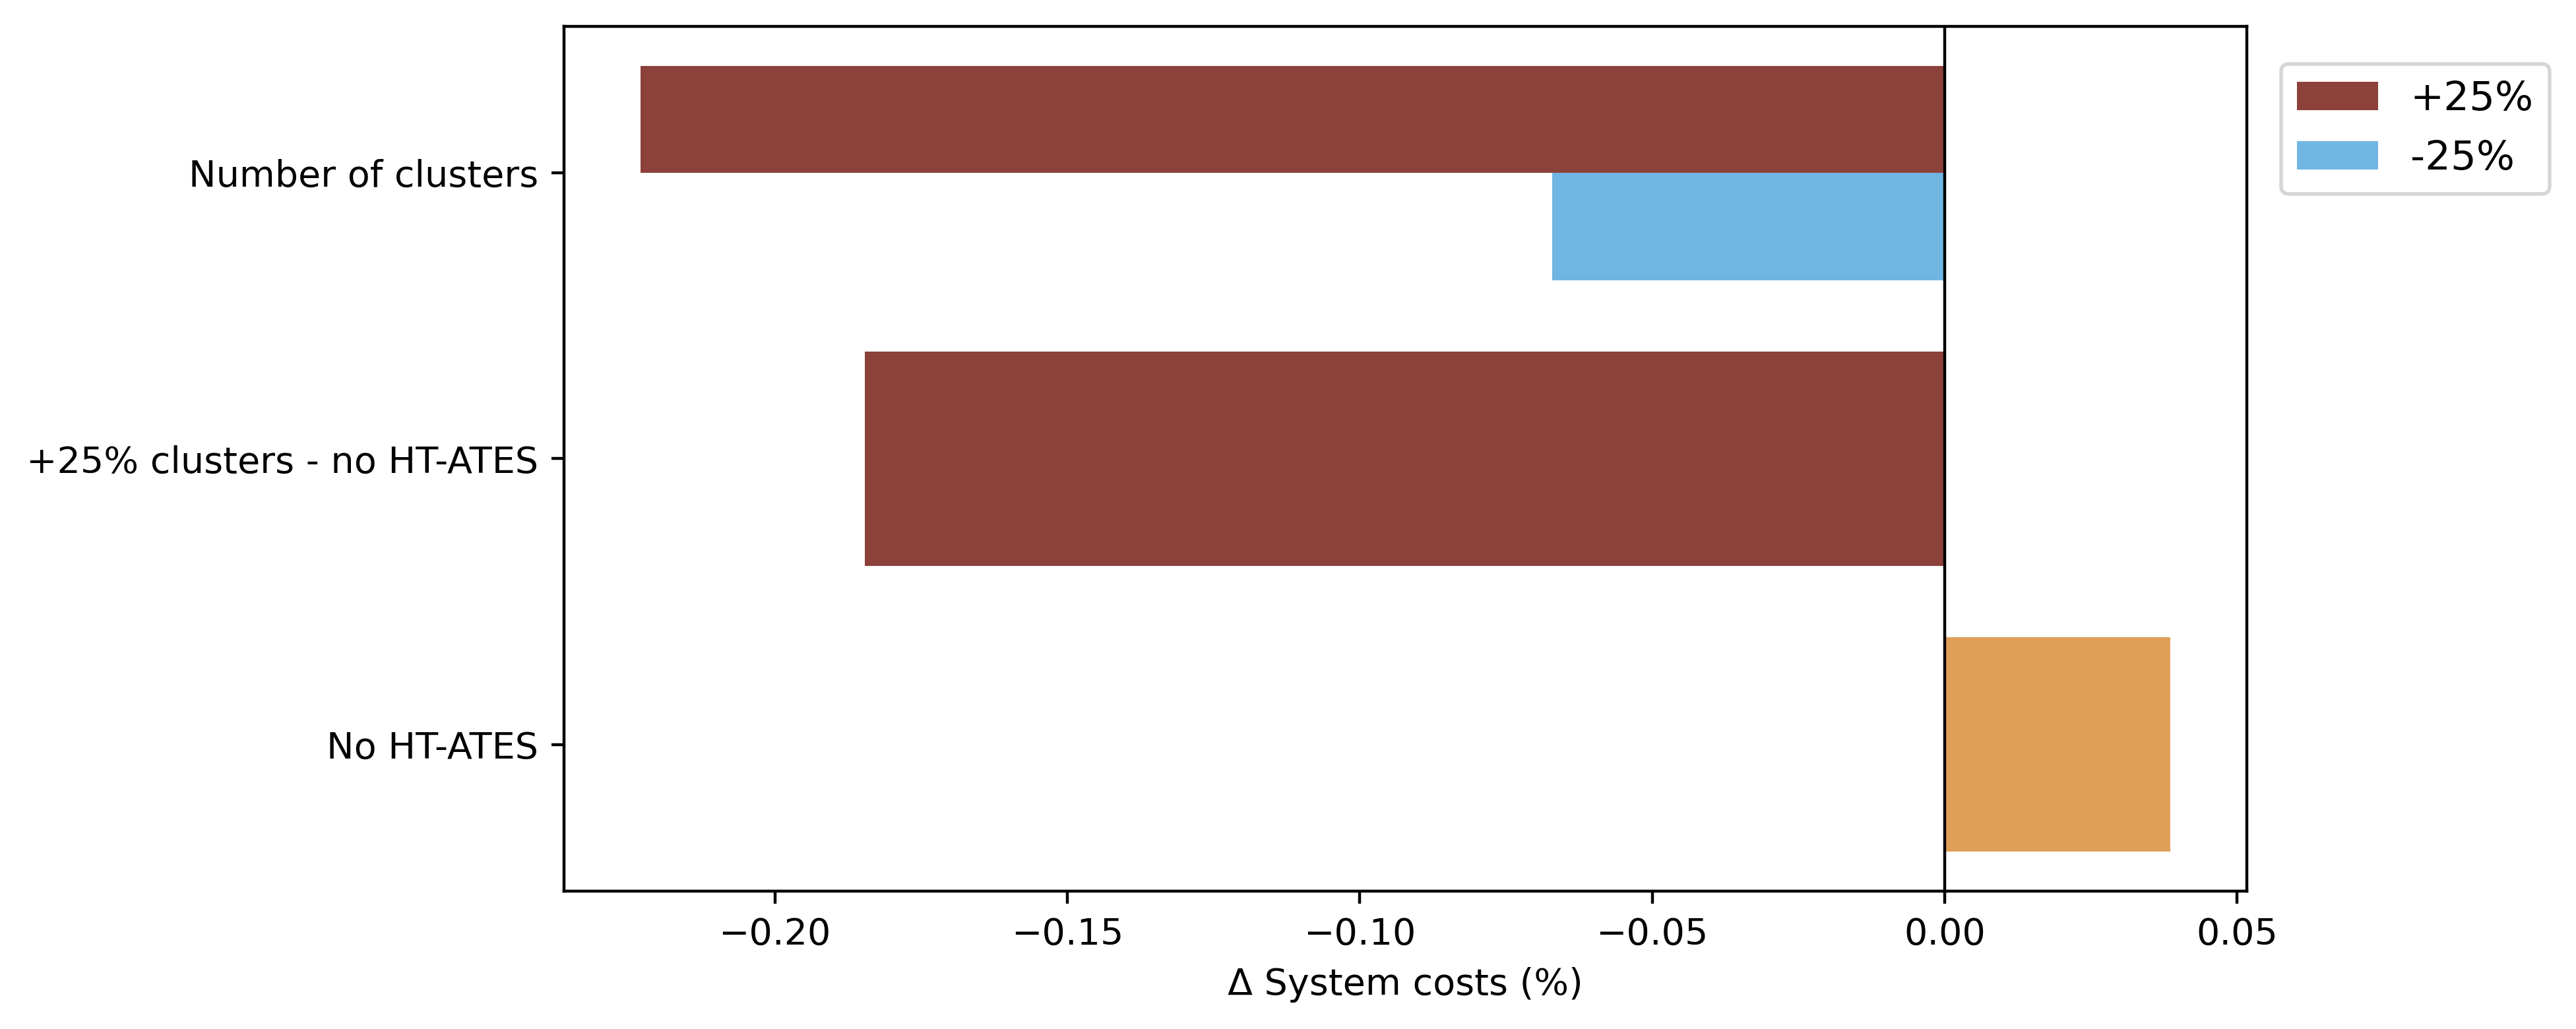

In [ ]:
csv_path = r"C:\Users\Johannes\Documents\final-results\nodal_costs"

# Map scenario keys to filenames
scenario_suffixes = {
    "n0": "nodal_costs_s_16__3H_2050-htates",
    "n1": "nodal_costs_s_16__3H_2050-htates-2",
    "n2": "nodal_costs_s_16__3H_2050-htates-3",
    "nc75": "nodal_costs_s_12__3H_2050",
    "nc125-2": "nodal_costs_s_20__3H_2050-nohtates",
    "nc125": "nodal_costs_s_20__3H_2050",
    "nnohtates": "nodal_costs_s_16__3H_2050-nohtates-3",
}
# Mapping of scenarios to parameters
parameter_map = {
    "nc75": ("Number of clusters", -25),
    "nc125": ("Number of clusters", +25),
    "nc125-2": ("+25% clusters - no HT-ATES", +25),
    "nnohtates": ("No HT-ATES", -100),
}
# Load costs
nodal_costs_billion_eur = {}
for name, filename in scenario_suffixes.items():
    file_path = os.path.join(csv_path, f"{filename}.csv")
    try:
        costs = pd.read_csv(file_path, header=[0], index_col=[0, 1, 2, 3])
        costs.index.names = ["cost", "component", "location", "carrier"]
        total_cost_nl = costs.sum().sum() / 1e9
        nodal_costs_billion_eur[name] = total_cost_nl
    except Exception as e:
        print(f"Error loading {name}: {e}")

# Create DataFrame
costs_df = pd.DataFrame.from_dict(nodal_costs_billion_eur, orient="index", columns=["Cost_BEUR"])
# Average base cost from n0–n3
base_keys = ["n0", "n1", "n2"]
base_cost = costs_df.loc[base_keys].mean().values[0]
print(f"\nAverage base cost from n0–n3: {base_cost:.4f} billion EUR")

# Build tornado-style table
plot_data = []
for key, (param, level) in parameter_map.items():
    delta = (costs_df.loc[key, "Cost_BEUR"] - base_cost) / base_cost * 100
    plot_data.append((param, level, delta))
tornado_df = pd.DataFrame(plot_data, columns=["Parameter", "Level", "Delta"])
# Pivot to have each parameter on its own row
pivot_df = tornado_df.pivot(index="Parameter", columns="Level", values="Delta")

# Add base cost range info (used for gray bar)
base_min = costs_df.loc[base_keys].min().values[0]
base_max = costs_df.loc[base_keys].max().values[0]
print(f"base max is {(base_max - base_min)/base_min *100} % higher than base min")
base_range = (base_max - base_min) / base_cost * 100  # in %

# Sort rows by absolute largest delta
pivot_df["__sort__"] = pivot_df.abs().max(axis=1)
pivot_df = pivot_df.sort_values("__sort__", ascending=True).drop(columns="__sort__")

std_dev_beur = 0.0001
std_dev_pct = std_dev_beur / base_cost * 100
print(f"Standard deviation in percentage: {std_dev_pct} %")

# Plot
fig, ax = plt.subplots(figsize=(10, 4), dpi=400)
bar_height = 0.75
y_pos = np.arange(len(pivot_df))

# Uncertainty bar for the uncertainty in the base costs
for y in y_pos:
    ax.barh(y, std_dev_pct, left=-std_dev_pct/2, height=bar_height, color="lightgray", alpha=0.3, zorder=0)

# Colors and labels
delta_colors = {
    -100: cm.managua(0.1),
    -50: cm.managua(0.7),
    -25: cm.managua(0.9),
     25: cm.managua(0.35),
     50: cm.managua(0.45),
     100: cm.managua(0.1),}
delta_labels = {
    -50: "-50%",
    -25: "-25%",
     25: "+25%",
     50: "+50%",}

seen_labels = set()

for i, (param, row) in enumerate(pivot_df.iterrows()):
    deltas = [d for d in delta_colors if d in row and not pd.isna(row[d])]
    n_bars = len(deltas)
    if n_bars == 0:
        continue
    # Height per bar without spacing
    h_per_bar = bar_height / n_bars
    # Start at bottom of row, stack upward
    base = y_pos[i] - bar_height / 2
    for j, delta in enumerate(deltas):
        bottom = base + j * h_per_bar
        label = delta_labels.get(delta) if delta in delta_labels and delta_labels[delta] not in seen_labels else None
        if label:
            seen_labels.add(label)
        ax.barh(bottom + h_per_bar / 2, row[delta], height=h_per_bar, color=delta_colors[delta], label=label)
print("The results that are depicted in the graph:")
print(pivot_df)
ax.set_yticks(y_pos)
ax.set_yticklabels(pivot_df.index)
ax.axvline(0, color="black", linewidth=0.8)
ax.set_xlabel("Δ System costs (%)")
#ax.set_title("System cost sensitivity for the whole network")
ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.98), fontsize=11)
plt.tight_layout()
plt.show()

Checking the difference between 2030 and 2050 cost assumptions

In [35]:
csv_path = r"C:\Users\Johannes\Documents\final-results\nodal_costs"

# Map scenario keys to filenames
scenario_suffixes = {
    "n0": "nodal_costs_s_16__3H_2050-htates",
    "n1": "nodal_costs_s_16__3H_2050-htates-2",
    "n2": "nodal_costs_s_16__3H_2050-htates-3",
    "nnohtates": "nodal_costs_s_16__3H_2050-nohtates-3",
    "ncost": "nodal_costs_s_16__3H_2050-cost2050",
    "nnohtatescost": "nodal_costs_s_16__3H_2050-nohtates-cost2050",
}
# Mapping of scenarios to parameters
parameter_map = {
    "ncost": ("2050 costs - HT-ATES", +100),
    "nnohtatescost": ("2050 costs - No HT-ATES", -100),
    "nnohtates": ("2030 costs - No HT-ATES", -100),
}
# Load costs
nodal_costs_billion_eur = {}
for name, filename in scenario_suffixes.items():
    file_path = os.path.join(csv_path, f"{filename}.csv")
    try:
        costs = pd.read_csv(file_path, header=[0], index_col=[0, 1, 2, 3])
        costs.index.names = ["cost", "component", "location", "carrier"]
        total_cost_nl = costs.sum().sum() / 1e9
        nodal_costs_billion_eur[name] = total_cost_nl
    except Exception as e:
        print(f"Error loading {name}: {e}")

# Create DataFrame
costs_df = pd.DataFrame.from_dict(nodal_costs_billion_eur, orient="index", columns=["Cost_BEUR"])
# Average base cost from n0–n3
base_keys = ["n0", "n1", "n2"]
base_cost = costs_df.loc[base_keys].mean().values[0]
print(f"\nAverage base cost from n0–n3: {base_cost:.4f} billion EUR")

# Build tornado-style table
plot_data = []
for key, (param, level) in parameter_map.items():
    delta = (costs_df.loc[key, "Cost_BEUR"] - base_cost) / base_cost * 100
    plot_data.append((param, level, delta))
tornado_df = pd.DataFrame(plot_data, columns=["Parameter", "Level", "Delta"])
# Pivot to have each parameter on its own row
pivot_df = tornado_df.pivot(index="Parameter", columns="Level", values="Delta")

# Add base cost range info (used for gray bar)
base_min = costs_df.loc[base_keys].min().values[0]
base_max = costs_df.loc[base_keys].max().values[0]
print(f"base max is {(base_max - base_min)/base_min *100} % higher than base min")
base_range = (base_max - base_min) / base_cost * 100  # in %

# Sort rows by absolute largest delta
pivot_df["__sort__"] = pivot_df.abs().max(axis=1)
pivot_df = pivot_df.sort_values("__sort__", ascending=True).drop(columns="__sort__")

std_dev_beur = 0.0001
std_dev_pct = std_dev_beur / base_cost * 100
print(f"Standard deviation in percentage: {std_dev_pct} %")

print("Change in total costs compared to 2050 with HT-ATES and 2030 cost assumptions:")
print(pivot_df)



Average base cost from n0–n3: 250.7027 billion EUR
base max is 0.00011079485143742698 % higher than base min
Standard deviation in percentage: 3.9887882846424295e-05 %
Change in total costs compared to 2050 with HT-ATES and 2030 cost assumptions:
Level                         -100        100
Parameter                                    
2030 costs - No HT-ATES   0.038626        NaN
2050 costs - No HT-ATES -13.074881        NaN
2050 costs - HT-ATES           NaN -13.093598
